# Imports

In [16]:
import os
from PIL import Image
from io import BytesIO
from urllib import request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#----------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#----------------------------------------------------------------------
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Reproduceability

In [3]:
# Define function to create dataframe
def create_dataframe(the_path):
    classes, class_paths = zip(*[(label, os.path.join(the_path, label, image))
                                 for label in os.listdir(the_path) if os.path.isdir(os.path.join(the_path, label))
                                 for image in os.listdir(os.path.join(the_path, label))])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    
    return df



# Define function to count images
def count_images(df):
    plt.figure(figsize=(15, 7))
    ax = sns.countplot(data=df , y=df['Class'])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Count of images in each class', fontsize=20)
    ax.bar_label(ax.containers[0])

    return plt.show();



# Define function to create test and valid data for training
def test_valid(ts_df_full):
    vd_df, ts_df = train_test_split(ts_df_full, train_size=0.5, random_state=20, stratify=ts_df_full['Class'])

    return vd_df, ts_df



# Define function to precess the data
def process_data(tr_df, vd_df, ts_df):
    rd_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

    ts_gen = ImageDataGenerator(rescale=1/255)
    
    
    tr_gen = rd_gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                      y_col='Class', batch_size=batch_size,
                                      target_size=img_size)
    
    vd_gen = rd_gen.flow_from_dataframe(vd_df, x_col='Class Path',
                                         y_col='Class', batch_size=batch_size,
                                         target_size=img_size)
    
    ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                      y_col='Class', batch_size=16,
                                      target_size=img_size, shuffle=False)

    return tr_gen, vd_gen, ts_gen



# Define function to show sample of data
def sample_data(tr_gen, ts_gen):
    class_dict = tr_gen.class_indices
    classes = list(class_dict.keys())
    images, labels = next(ts_gen)
    
    plt.figure(figsize=(15, 15))
    
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(4,4, i + 1)
        plt.imshow(image)
        class_name = classes[np.argmax(label)]
        plt.title(class_name, color='k', fontsize=15)
    
    return plt.show();



# Define function to create model
def create_model(base_model, LEARNING_RATE):
    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate= 0.3),
        Dense(128, activation= 'relu'),
        Dropout(rate= 0.25),
        Dense(4, activation= 'softmax')
    ])
    
    model.compile(Adamax(learning_rate=LEARNING_RATE),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy',
                            Precision(),
                            Recall()])
    
    summary = model.summary()
    
    return model, summary



# Define function to train model
def train_model(tr_gen, vd_gen):
    hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=vd_gen,
                 shuffle= False)

    return hist



# Define function to show performance
def show_performance(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    tr_per = hist.history['precision']
    tr_recall = hist.history['recall']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    val_per = hist.history['val_precision']
    val_recall = hist.history['val_recall']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_precision = np.argmax(val_per)
    per_highest = val_per[index_precision]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]
    
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    per_label = f'Best epoch = {str(index_precision + 1)}'
    recall_label = f'Best epoch = {str(index_recall + 1)}'
        
    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')
        
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Precision and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    
    return plt.show();



# Define function to eveluate results
def evaluate_results(tr_gen, vd_gen, ts_gen):
    train_score = model.evaluate(tr_gen, verbose=1)
    valid_score = model.evaluate(vd_gen, verbose=1)
    test_score = model.evaluate(ts_gen, verbose=1)
    
    print(f"\nTrain Loss: {train_score[0]:.4f}")
    print(f"Train Accuracy: {train_score[1]*100:.2f}%")
    print('-' * 25)
    print(f"Validation Loss: {valid_score[0]:.4f}")
    print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
    print('-' * 25)
    print(f"Test Loss: {test_score[0]:.4f}")
    print(f"Test Accuracy: {test_score[1]*100:.2f}%")

# Data

In [4]:
# Create and show the training dataframe
tr_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
tr_df = create_dataframe(tr_path)
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [5]:
# Create and show the full test data
ts_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'
ts_df_full = create_dataframe(ts_path)
ts_df_full

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


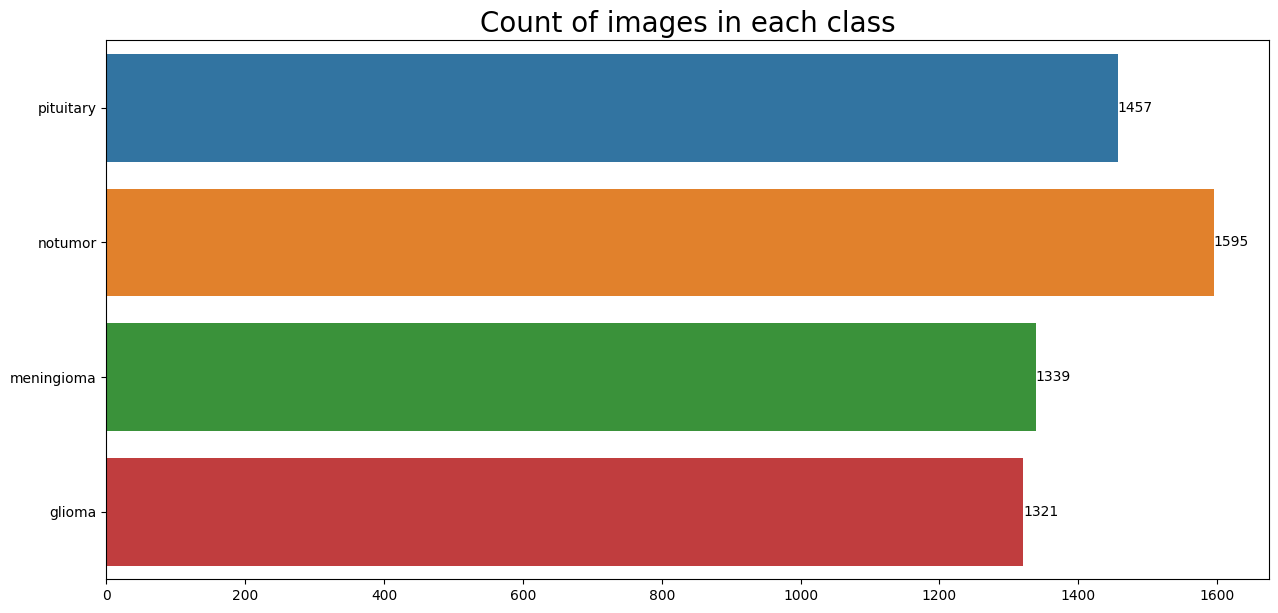

In [6]:
# Count training data classes and plot
count_images(tr_df)

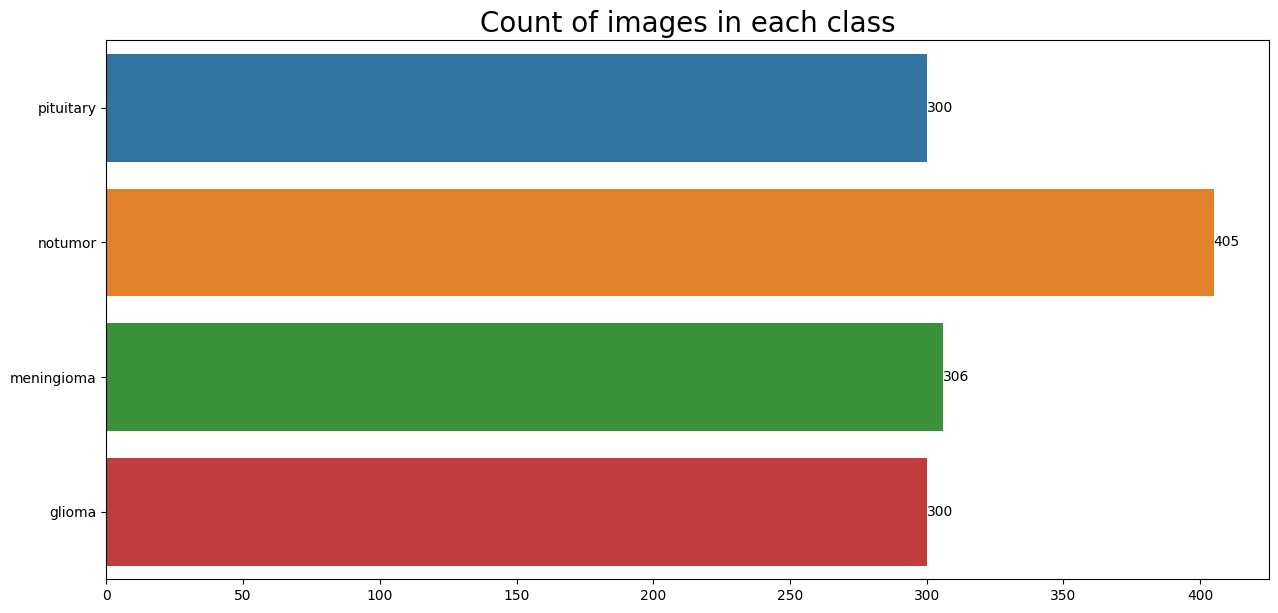

In [7]:
# Count full test data classes and plot
count_images(ts_df_full)

In [8]:
# Create test and valid data for training
vd_df, ts_df = test_valid(ts_df_full)

In [9]:
# Show validation database
vd_df

,Class Path,Class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1070,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
554,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1284,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
899,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


In [10]:
# Show testing database
ts_df

,Class Path,Class
971,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1169,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
888,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
494,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
610,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
365,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1282,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
950,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
727,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


# Preprocessing

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.



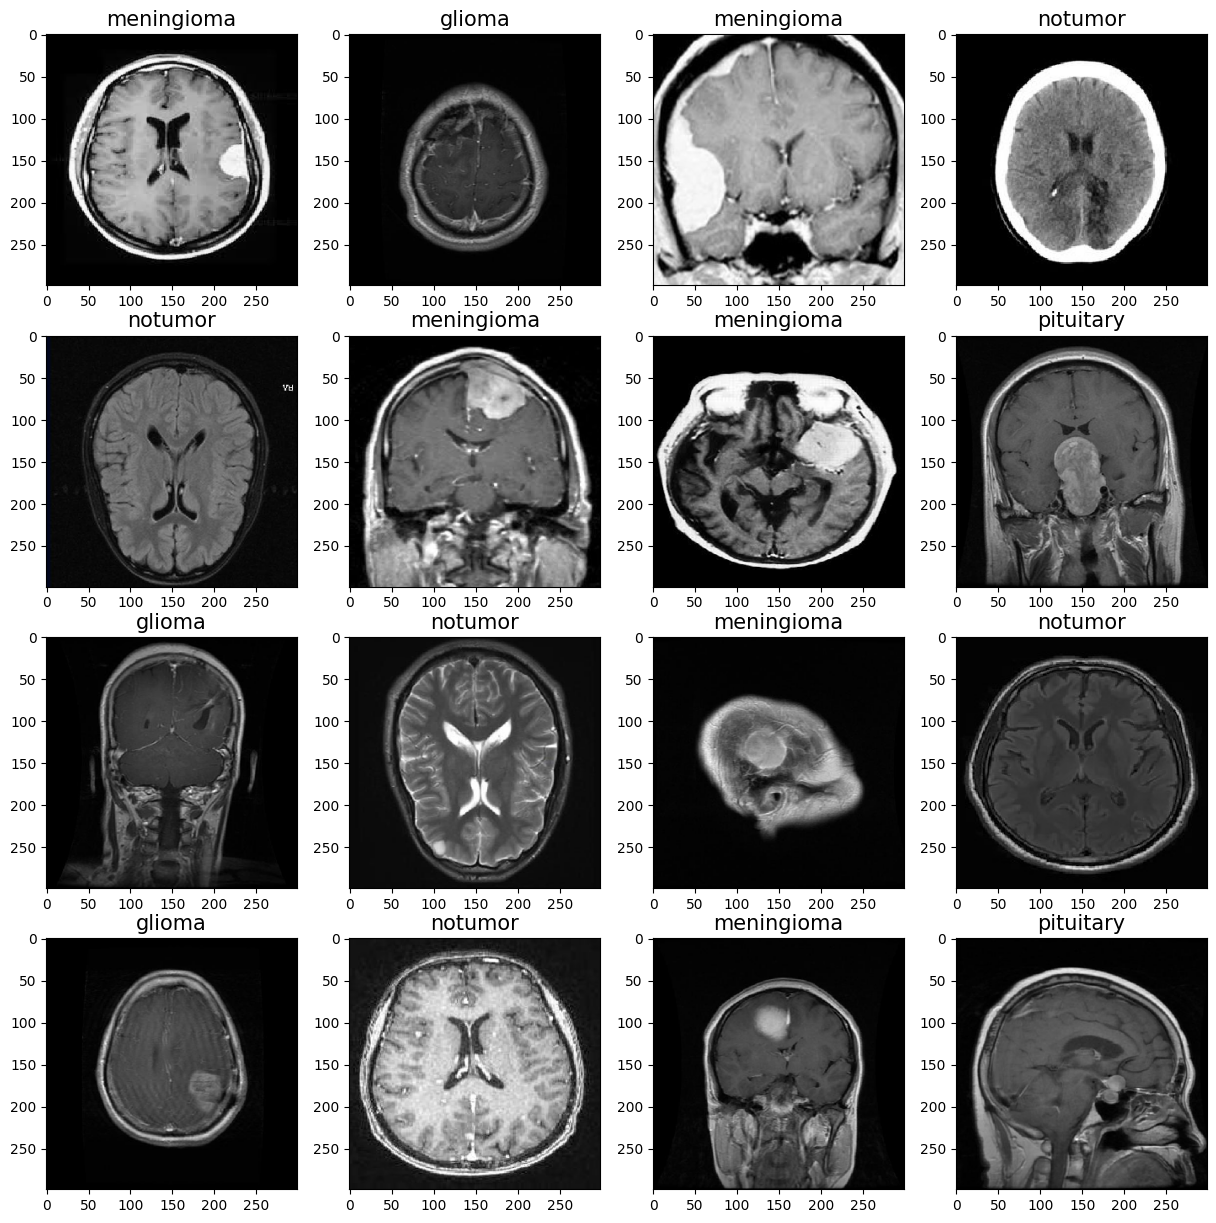

In [11]:
# Define constants
batch_size = 32
img_size = (299, 299)

# Process the dataframes
tr_gen, vd_gen, ts_gen = process_data(tr_df, vd_df, ts_df)
print()

# Sample some data and show
sample_data(tr_gen, ts_gen)

# Xception

## Model

In [12]:
# Create model
LEARNING_RATE = 0.001
img_shape=(299,299,3)
base_model = base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model, summary = create_model(base_model, LEARNING_RATE)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Training

In [13]:
# Train model
hist = train_model(tr_gen, vd_gen)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7517 - loss: 0.7200 - precision: 0.8390 - recall: 0.6437 - val_accuracy: 0.9481 - val_loss: 0.1388 - val_precision: 0.9524 - val_recall: 0.9466
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 847ms/step - accuracy: 0.9837 - loss: 0.0530 - precision: 0.9858 - recall: 0.9820 - val_accuracy: 0.9786 - val_loss: 0.0550 - val_precision: 0.9786 - val_recall: 0.9756
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 844ms/step - accuracy: 0.9881 - loss: 0.0380 - precision: 0.9891 - recall: 0.9867 - val_accuracy: 0.9771 - val_loss: 0.0588 - val_precision: 0.9771 - val_recall: 0.9756
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 844ms/step - accuracy: 0.9938 - loss: 0.0200 - precision: 0.9941 - recall: 0.9938 - val_accuracy: 0.9771 - val_loss: 0.1115 - val_precision: 0.9771 - val_recall: 0.9771
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 844ms/step - accuracy: 0.9941 - loss: 0.0188 - precision: 0.9941 - recall: 0.9941 - val_accuracy: 0.99

## Performance

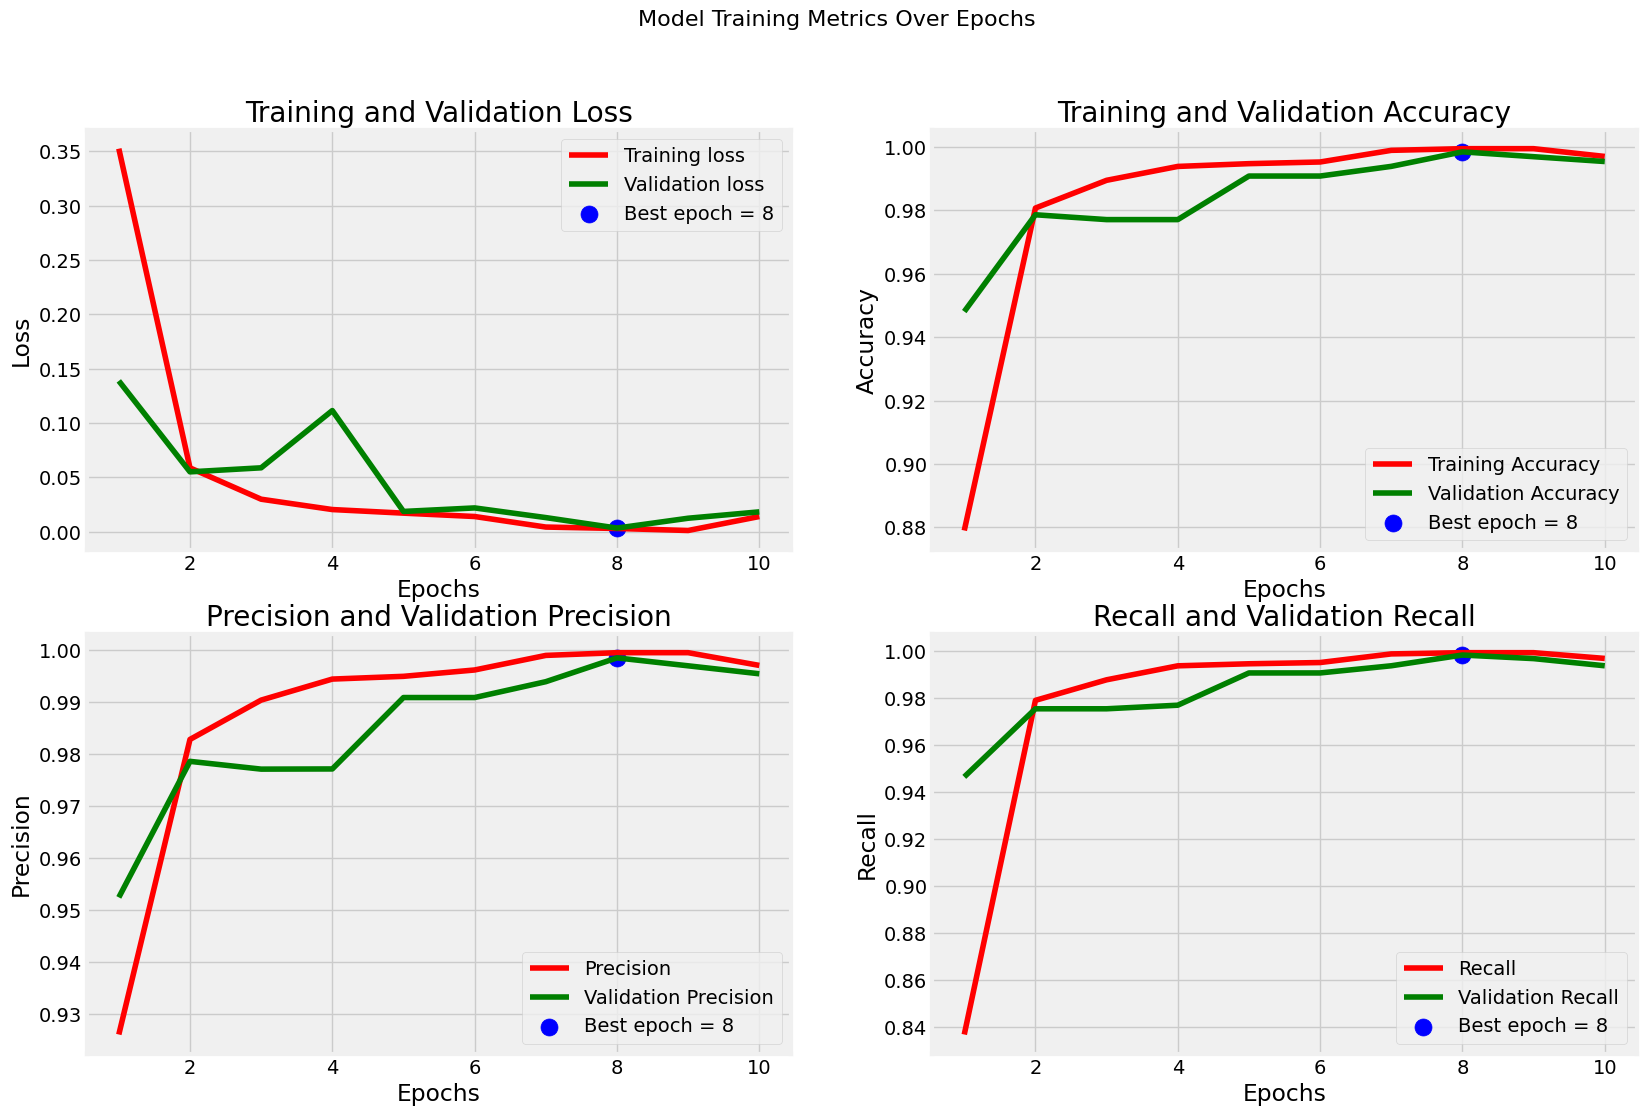

In [14]:
# Show performance
show_performance(hist)

## Results

In [15]:
# Eveluate results
evaluate_results(tr_gen, vd_gen, ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 1.0000 - loss: 7.3586e-04 - precision: 1.0000 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.9921 - loss: 0.0307 - precision: 0.9921 - recall: 0.9921
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9974 - loss: 0.0331 - precision: 0.9974 - recall: 0.9974

Train Loss: 0.0003
Train Accuracy: 100.00%
-------------------------
Validation Loss: 0.0175
Validation Accuracy: 99.39%
-------------------------
Test Loss: 0.0697
Test Accuracy: 99.39%


In [21]:
# Save as keras model
tf.keras.models.save_model(model, 'brain_tumor_model.keras')

In [22]:
# Load the model
loaded_model = tf.keras.models.load_model('/kaggle/working/brain_tumor_model.keras')

In [23]:
# Define the convereter
converter = tflite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp1r0ajgld'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135802930794512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802930804896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802931577248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802930800320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802930802608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802930801376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802931583584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802931587280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802931583408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802931586576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1358029315908

In [24]:
# Save the converted model
with open('/kaggle/working/brain_tumor_model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

In [25]:
# Define the interpreter.
interpreter = tflite.Interpreter(model_path='/kaggle/working/brain_tumor_model.tflite')
interpreter.allocate_tensors()

In [26]:
# Show the input_index details
input_index_details = interpreter.get_input_details()
input_index_details

[{'name': 'serving_default_input_layer_1:0',
  'index': 0,
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [27]:
# Return the input_index.
input_index = interpreter.get_input_details()[0]['index']
input_index

0

In [28]:
# Return the output_index.
output_index = interpreter.get_output_details()[0]['index']
output_index

232

In [29]:
# Define the download_image function.
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

In [30]:
# Define the prepare_image function.
def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [31]:
# Define the pre_process function.
def pre_process(x):
    return x / 255.0

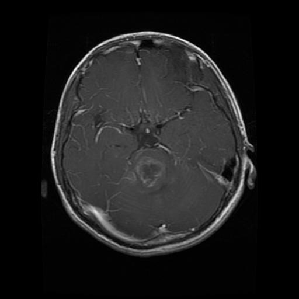

In [44]:
# Import image and show
img = tf.keras.utils.load_img('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg', target_size=(299, 299))
img

In [45]:
# Pre process image.
x = np.array(img, dtype='float32')
X = np.array([x])
X = pre_process(X)

In [46]:
# Return the output of the model.
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
preds

array([[1.0000000e+00, 1.5787294e-09, 6.4782117e-11, 4.0334552e-10]],
      dtype=float32)

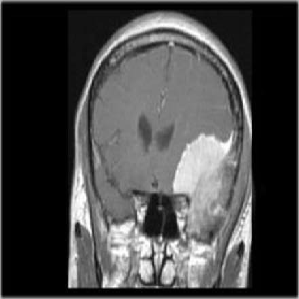

In [49]:
# Import image and show
img = tf.keras.utils.load_img('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg', target_size=(299, 299))
img

In [50]:
# Pre process image.
x = np.array(img, dtype='float32')
X = np.array([x])
X = pre_process(X)

In [51]:
# Return the output of the model.
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
preds

array([[1.7612139e-08, 9.9999976e-01, 1.9678328e-08, 2.6377060e-07]],
      dtype=float32)

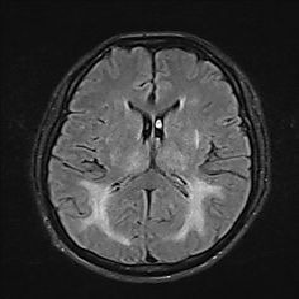

In [38]:
# Import image and show
img = tf.keras.utils.load_img('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg', target_size=(299, 299))
img

In [39]:
# Pre process image.
x = np.array(img, dtype='float32')
X = np.array([x])
X = pre_process(X)

In [40]:
# Return the output of the model.
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
preds

array([[4.181358e-09, 3.476937e-07, 9.999995e-01, 9.547453e-08]],
      dtype=float32)

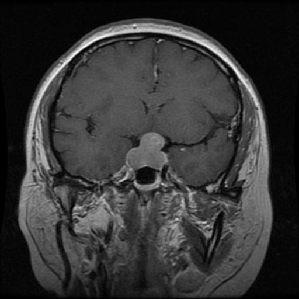

In [41]:
# Import image and show
img = tf.keras.utils.load_img('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg', target_size=(299, 299))
img

In [42]:
# Pre process image.
x = np.array(img, dtype='float32')
X = np.array([x])
X = pre_process(X)

In [43]:
# Return the output of the model.
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
preds

array([[2.8590916e-09, 1.4562028e-10, 2.3143163e-09, 1.0000000e+00]],
      dtype=float32)

# InceptionV3

# Data

In [15]:
# Create training dataframe
tr_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
tr_df = create_dataframe(tr_path)

# Create full test data
ts_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'
ts_df_full = create_dataframe(ts_path)

# Create test and valid data for training
vd_df, ts_df = test_valid(ts_df_full)

# Define constants
batch_size = 32
img_size = (299, 299)

# Process the dataframes
tr_gen, vd_gen, ts_gen = process_data(tr_df, vd_df, ts_df)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Model

In [16]:
# Create model
LEARNING_RATE = 0.001
img_shape=(299,299,3)
base_model = base_model = tf.keras.applications.InceptionV3(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model, summary = create_model(base_model, LEARNING_RATE)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,572 (84.17 MB)

 Trainable params: 22,031,140 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

## Train

In [17]:
# Train model
train_model(tr_gen, vd_gen)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 234s 822ms/step - accuracy: 0.7682 - loss: 1.2906 - precision_1: 0.7833 - recall_1: 0.7496 - val_accuracy: 0.8916 - val_loss: 0.3366 - val_precision_1: 0.9052 - val_recall_1: 0.8748
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9552 - loss: 0.1278 - precision_1: 0.9610 - recall_1: 0.9499 - val_accuracy: 0.8870 - val_loss: 0.3508 - val_precision_1: 0.8974 - val_recall_1: 0.8809
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 453ms/step - accuracy: 0.9786 - loss: 0.0736 - precision_1: 0.9827 - recall_1: 0.9765 - val_accuracy: 0.9405 - val_loss: 0.2963 - val_precision_1: 0.9415 - val_recall_1: 0.9344
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 453ms/step - accuracy: 0.9717 - loss: 0.0923 - precision_1: 0.9729 - recall_1: 0.9707 - val_accuracy: 0.9466 - val_loss: 0.1542 - val_precision_1: 0.9519 - val_recall_1: 0.9374
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.9871 - loss: 0.0357 - precision_1: 0.9878 - re

# Performance

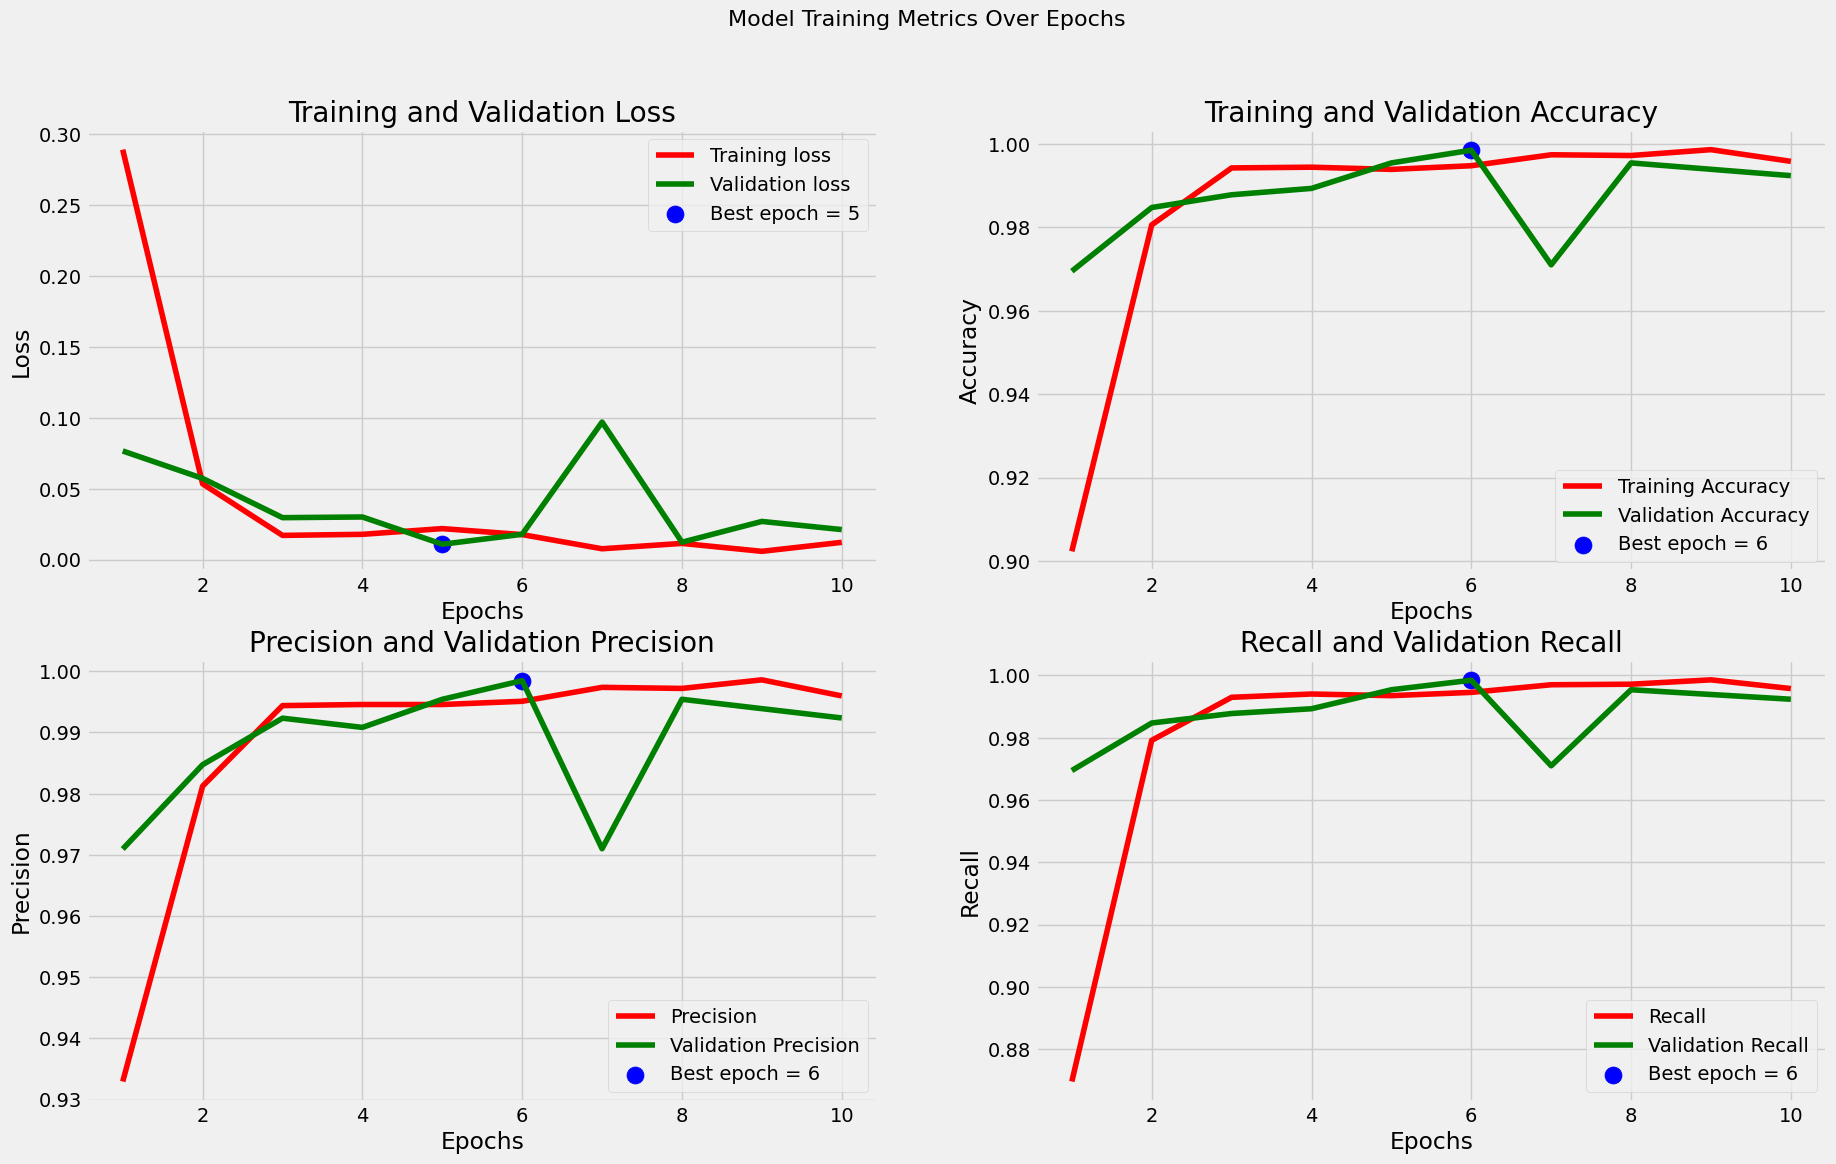

In [27]:
# Show performance
show_performance(hist)

## Results

In [28]:
# Eveluate results
evaluate_results(tr_gen, vd_gen, ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9946 - loss: 0.0163 - precision_1: 0.9953 - recall_1: 0.9941
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9867 - loss: 0.0366 - precision_1: 0.9882 - recall_1: 0.9865
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9876 - loss: 0.0391 - precision_1: 0.9885 - recall_1: 0.9876

Train Loss: 0.0195
Train Accuracy: 99.35%
-------------------------
Validation Loss: 0.0411
Validation Accuracy: 98.63%
-------------------------
Test Loss: 0.0740
Test Accuracy: 98.32%


# ResNet101V2

## Data

In [34]:
# Create training dataframe
tr_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
tr_df = create_dataframe(tr_path)

# Create full test data
ts_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'
ts_df_full = create_dataframe(ts_path)

# Create test and valid data for training
vd_df, ts_df = test_valid(ts_df_full)

# Define constants
batch_size = 32
img_size = (299, 299)

# Process the dataframes
tr_gen, vd_gen, ts_gen = process_data(tr_df, vd_df, ts_df)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Model

In [35]:
# Create model
LEARNING_RATE = 0.001
img_shape=(299,299,3)
base_model = base_model = tf.keras.applications.ResNet101V2(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model, summary = create_model(base_model, LEARNING_RATE)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,889,348 (163.61 MB)

 Trainable params: 42,791,684 (163.24 MB)

 Non-trainable params: 97,664 (381.50 KB)

## Training

In [36]:
# Train model
train_model(tr_gen, vd_gen)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7414 - loss: 2.1872 - precision_2: 0.7553 - recall_2: 0.7222 - val_accuracy: 0.8107 - val_loss: 0.5356 - val_precision_2: 0.8315 - val_recall_2: 0.7908
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 848ms/step - accuracy: 0.9182 - loss: 0.2630 - precision_2: 0.9303 - recall_2: 0.9032 - val_accuracy: 0.9298 - val_loss: 0.1894 - val_precision_2: 0.9424 - val_recall_2: 0.9237
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 849ms/step - accuracy: 0.9512 - loss: 0.1391 - precision_2: 0.9548 - recall_2: 0.9477 - val_accuracy: 0.8901 - val_loss: 0.2669 - val_precision_2: 0.8952 - val_recall_2: 0.8870
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 850ms/step - accuracy: 0.9642 - loss: 0.1113 - precision_2: 0.9671 - recall_2: 0.9608 - val_accuracy: 0.9542 - val_loss: 0.1217 - val_precision_2: 0.9541 - val_recall_2: 0.9511
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 848ms/step - accuracy: 0.9785 - loss: 0.0658 - precision_2: 0.9801 - r

## Performance

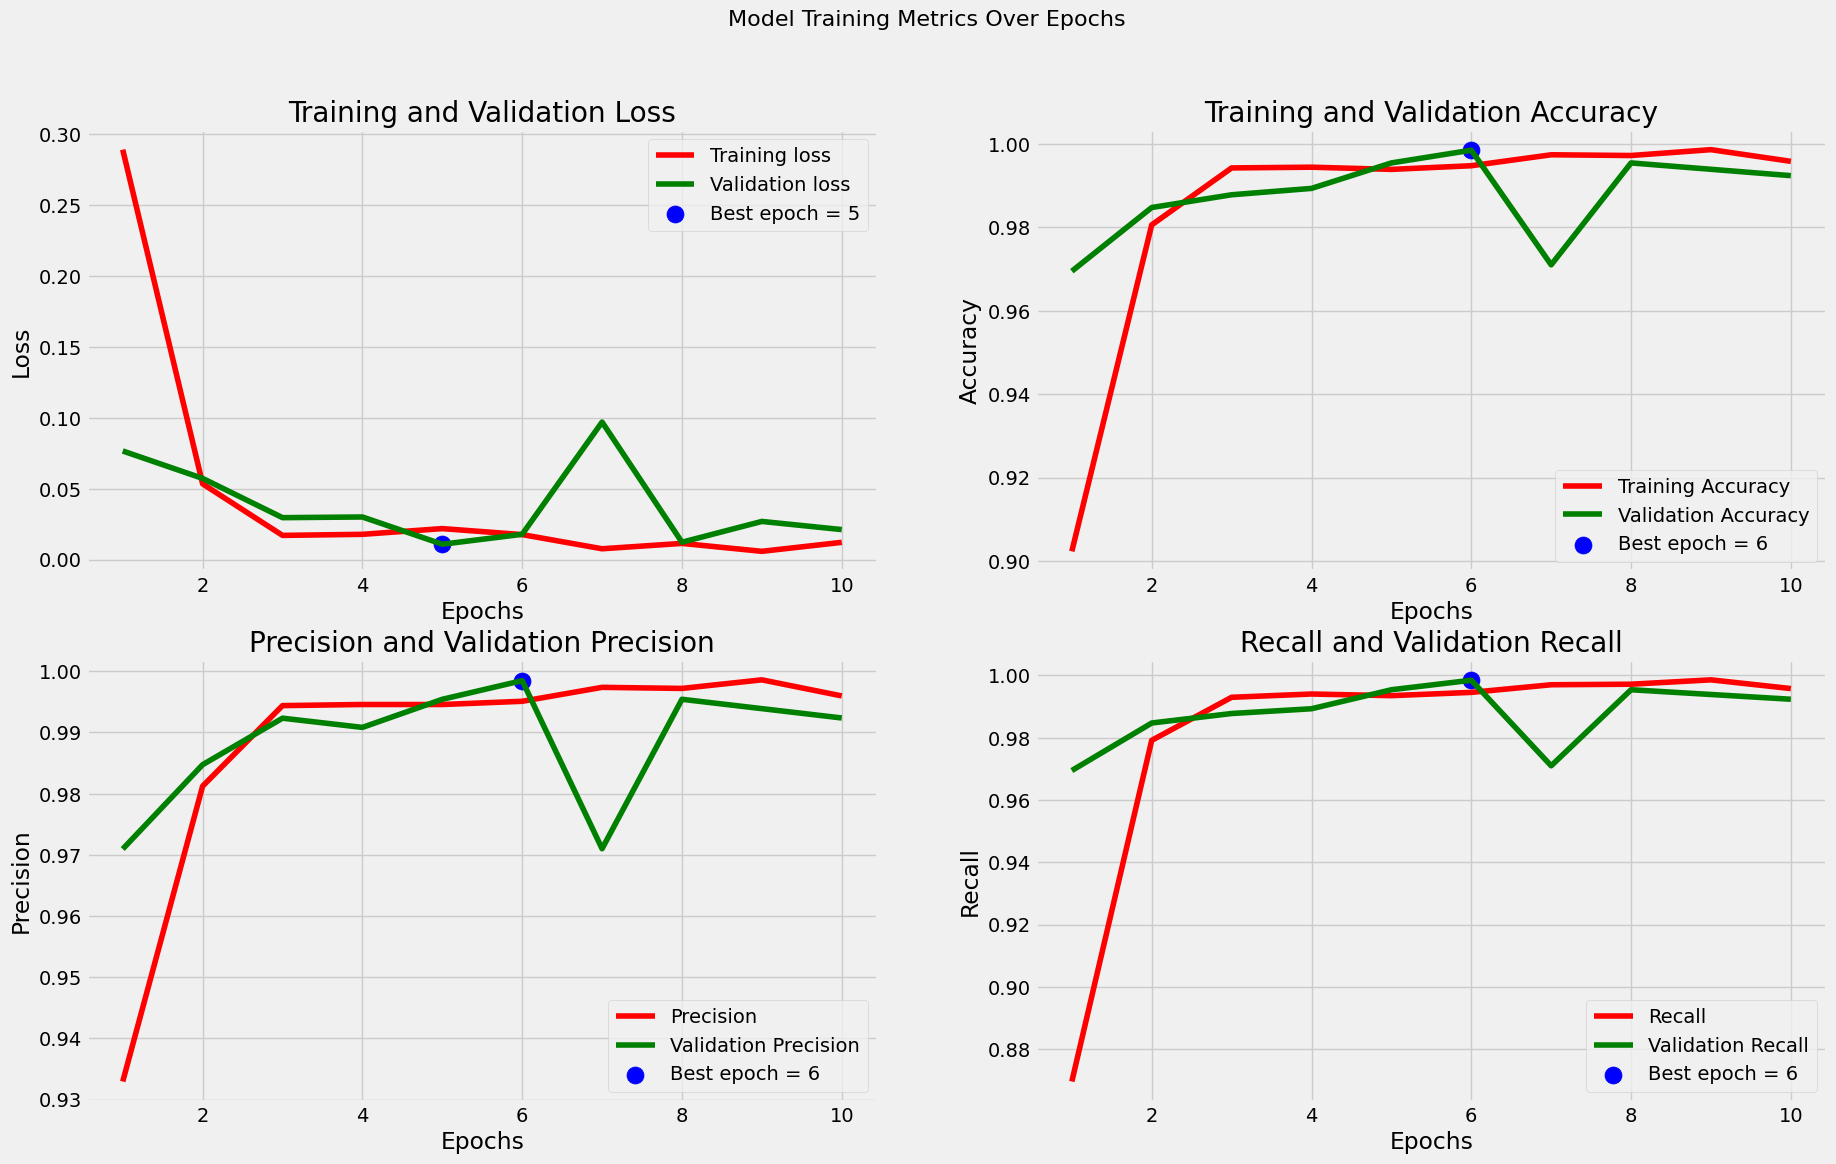

In [37]:
# Show performance
show_performance(hist)

## Results

In [38]:
# Eveluate results
evaluate_results(tr_gen, vd_gen, ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.9860 - loss: 0.0403 - precision_2: 0.9862 - recall_2: 0.9860
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9527 - loss: 0.1658 - precision_2: 0.9527 - recall_2: 0.9527
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9744 - loss: 0.0887 - precision_2: 0.9755 - recall_2: 0.9744

Train Loss: 0.0425
Train Accuracy: 98.55%
-------------------------
Validation Loss: 0.1616
Validation Accuracy: 95.88%
-------------------------
Test Loss: 0.1323
Test Accuracy: 96.80%


# Xception - learning_rate 0.0005

## Data

In [39]:
# Create training dataframe
tr_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
tr_df = create_dataframe(tr_path)

# Create full test data
ts_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'
ts_df_full = create_dataframe(ts_path)

# Create test and valid data for training
vd_df, ts_df = test_valid(ts_df_full)

# Define constants
batch_size = 32
img_size = (299, 299)

# Process the dataframes
tr_gen, vd_gen, ts_gen = process_data(tr_df, vd_df, ts_df)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Model

In [40]:
# Create model
LEARNING_RATE = 0.0005
img_shape=(299,299,3)
base_model = base_model = tf.keras.applications.ResNet101V2(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model, summary = create_model(base_model, LEARNING_RATE)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,889,348 (163.61 MB)

 Trainable params: 42,791,684 (163.24 MB)

 Non-trainable params: 97,664 (381.50 KB)

## Training

In [41]:
# Train model
train_model(tr_gen, vd_gen)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.7190 - loss: 2.4970 - precision_3: 0.7235 - recall_3: 0.7153 - val_accuracy: 0.8351 - val_loss: 0.4587 - val_precision_3: 0.8721 - val_recall_3: 0.7908
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 849ms/step - accuracy: 0.9304 - loss: 0.1987 - precision_3: 0.9398 - recall_3: 0.9210 - val_accuracy: 0.8931 - val_loss: 0.2934 - val_precision_3: 0.9195 - val_recall_3: 0.8718
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 849ms/step - accuracy: 0.9506 - loss: 0.1364 - precision_3: 0.9553 - recall_3: 0.9471 - val_accuracy: 0.9298 - val_loss: 0.1782 - val_precision_3: 0.9478 - val_recall_3: 0.9145
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 851ms/step - accuracy: 0.9699 - loss: 0.0821 - precision_3: 0.9723 - recall_3: 0.9688 - val_accuracy: 0.9603 - val_loss: 0.1234 - val_precision_3: 0.9631 - val_recall_3: 0.9573
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 847ms/step - accuracy: 0.9766 - loss: 0.0696 - precision_3: 0.9780 - r

## Performance

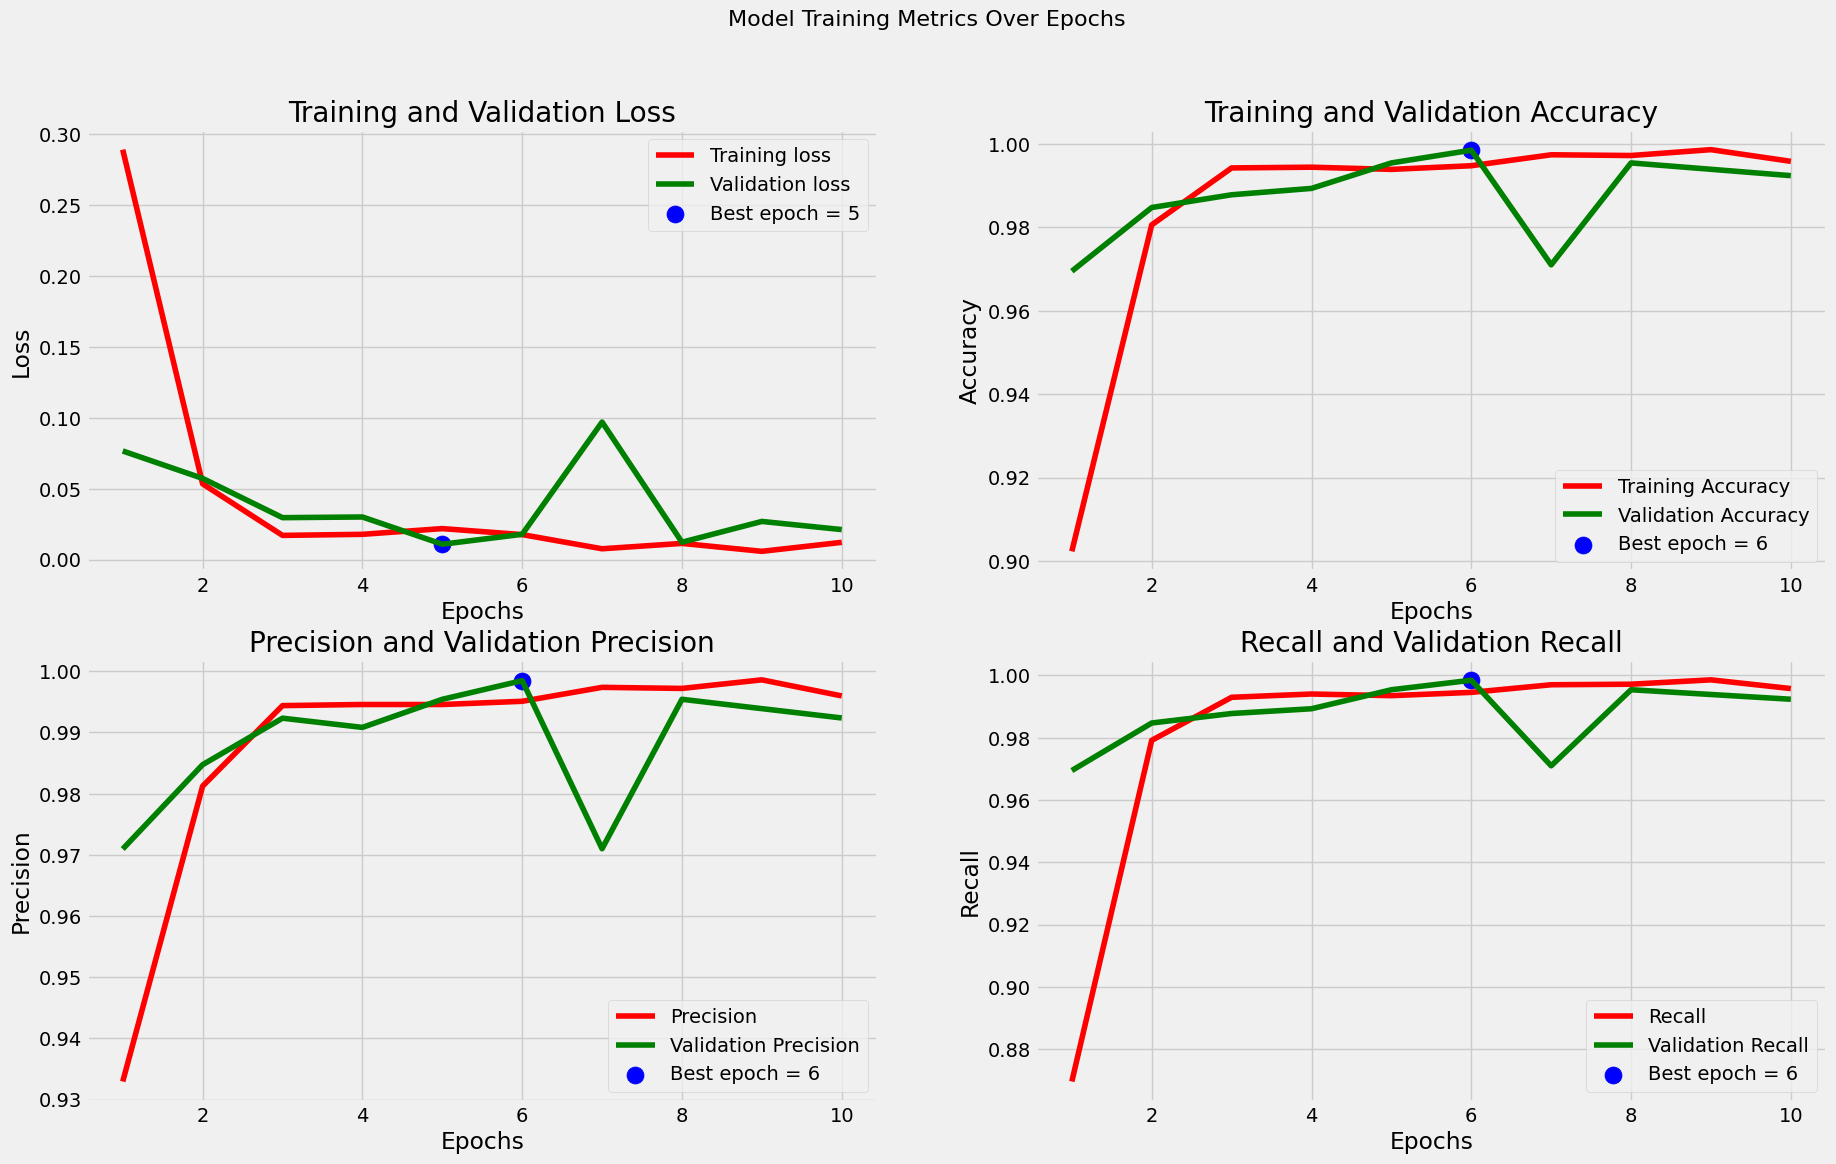

In [44]:
# Show performance
show_performance(hist)

## Results

In [43]:
# Eveluate results
evaluate_results(tr_gen, vd_gen, ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.9969 - loss: 0.0134 - precision_3: 0.9970 - recall_3: 0.9969
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9854 - loss: 0.0462 - precision_3: 0.9854 - recall_3: 0.9842
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9829 - loss: 0.0902 - precision_3: 0.9829 - recall_3: 0.9817

Train Loss: 0.0148
Train Accuracy: 99.63%
-------------------------
Validation Loss: 0.0804
Validation Accuracy: 98.47%
-------------------------
Test Loss: 0.1169
Test Accuracy: 98.02%


# Xception - learning_rate 0.0009

## Data

In [48]:
# Create training dataframe
tr_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
tr_df = create_dataframe(tr_path)

# Create full test data
ts_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'
ts_df_full = create_dataframe(ts_path)

# Create test and valid data for training
vd_df, ts_df = test_valid(ts_df_full)

# Define constants
batch_size = 32
img_size = (299, 299)

# Process the dataframes
tr_gen, vd_gen, ts_gen = process_data(tr_df, vd_df, ts_df)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Model

In [49]:
# Create model
LEARNING_RATE = 0.0005
img_shape=(299,299,3)
base_model = base_model = tf.keras.applications.ResNet101V2(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

model, summary = create_model(base_model, LEARNING_RATE)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 2048)                │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,889,348 (163.61 MB)

 Trainable params: 42,791,684 (163.24 MB)

 Non-trainable params: 97,664 (381.50 KB)

## Training

In [50]:
# Train model
train_model(tr_gen, vd_gen)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.3692 - loss: 5.1662 - precision_5: 0.5477 - recall_5: 0.1210 - val_accuracy: 0.2779 - val_loss: 4.1602 - val_precision_5: 0.2878 - val_recall_5: 0.2733
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 815ms/step - accuracy: 0.5046 - loss: 1.1169 - precision_5: 0.7491 - recall_5: 0.2399 - val_accuracy: 0.4443 - val_loss: 2.0632 - val_precision_5: 0.5714 - val_recall_5: 0.2992
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 812ms/step - accuracy: 0.5231 - loss: 1.1016 - precision_5: 0.7520 - recall_5: 0.2680 - val_accuracy: 0.5176 - val_loss: 1.0893 - val_precision_5: 0.7281 - val_recall_5: 0.2534
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 816ms/step - accuracy: 0.5849 - loss: 1.0742 - precision_5: 0.7661 - recall_5: 0.3311 - val_accuracy: 0.5542 - val_loss: 1.2276 - val_precision_5: 0.6257 - val_recall_5: 0.3191
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 817ms/step - accuracy: 0.6021 - loss: 0.9600 - precision_5: 0.8081 - r

## Performance

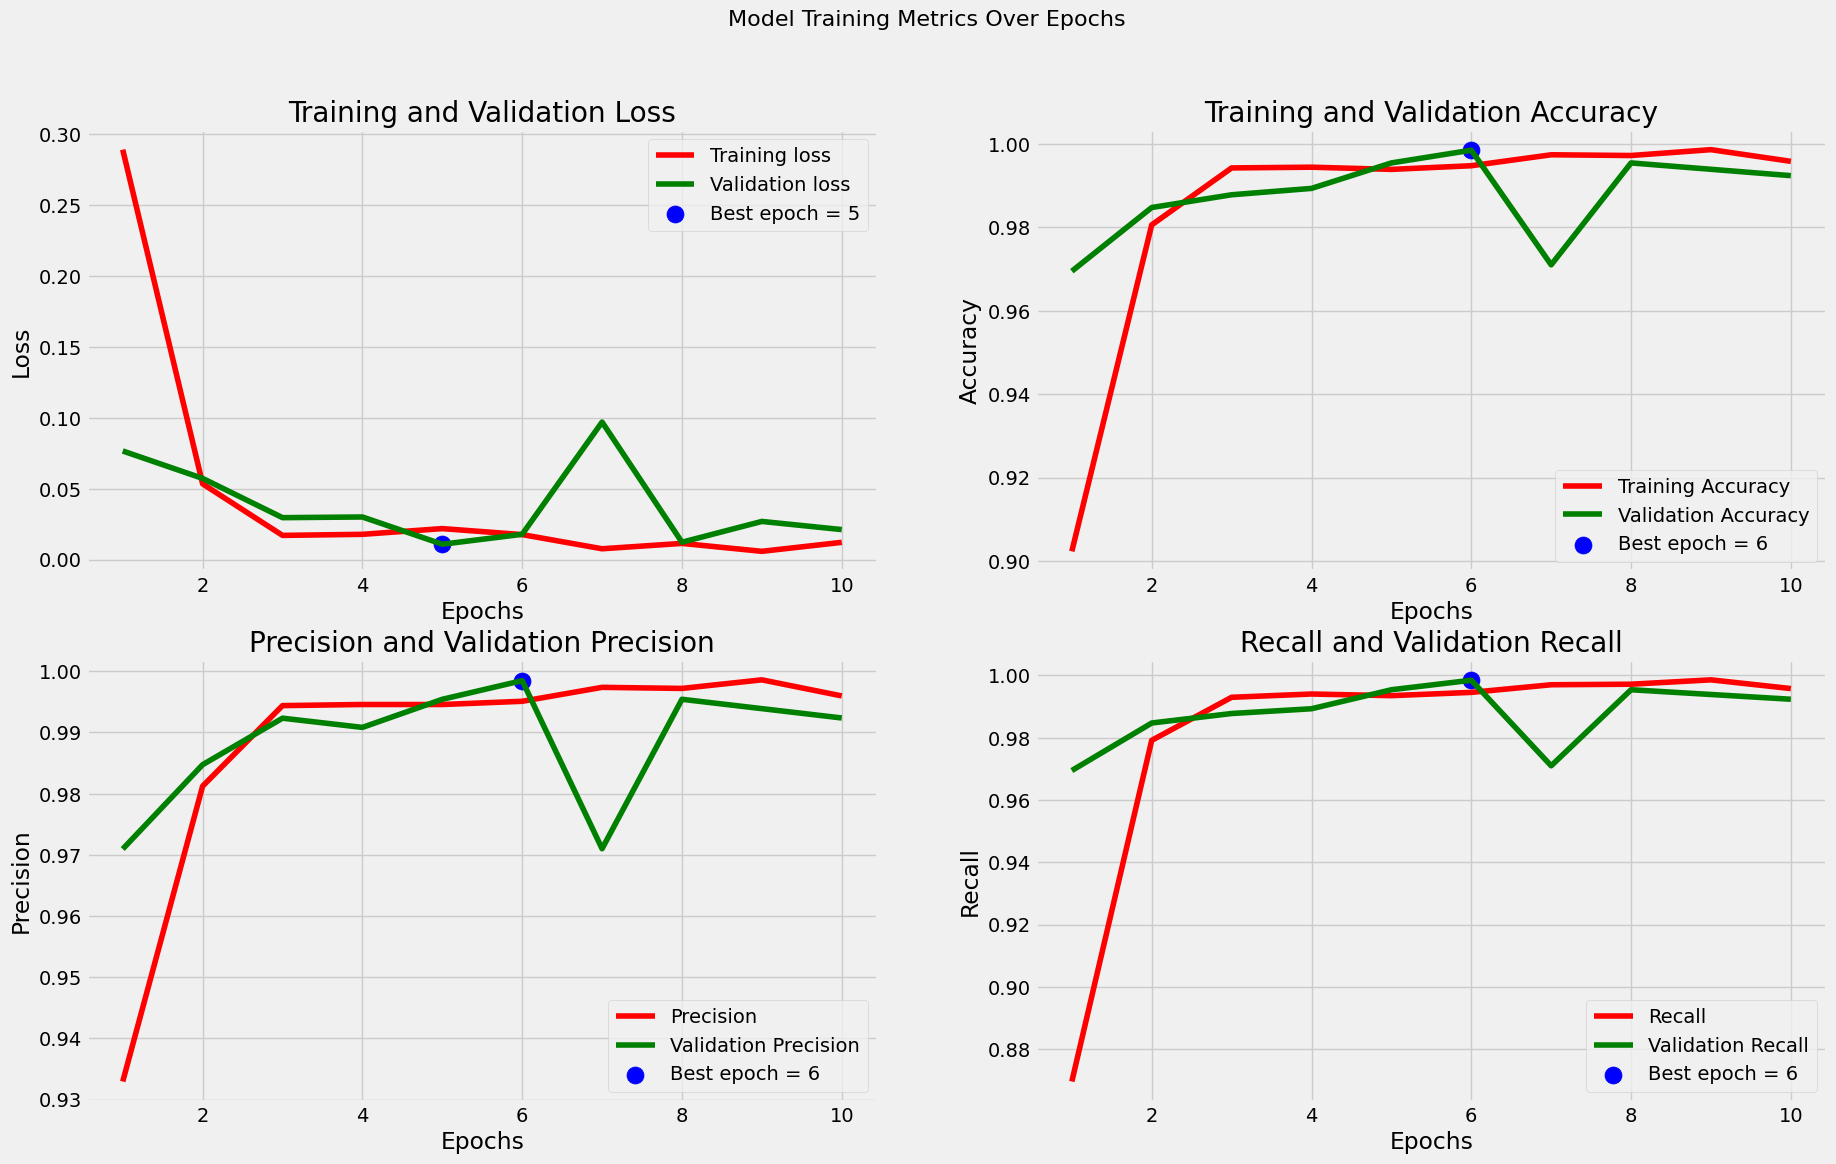

In [51]:
# Show performance
show_performance(hist)

## Results

In [52]:
# Eveluate results
evaluate_results(tr_gen, vd_gen, ts_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.6722 - loss: 0.9977 - precision_5: 0.6871 - recall_5: 0.6550
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7008 - loss: 0.9630 - precision_5: 0.7088 - recall_5: 0.6679
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6866 - loss: 1.0640 - precision_5: 0.6972 - recall_5: 0.6669

Train Loss: 1.0086
Train Accuracy: 67.37%
-------------------------
Validation Loss: 0.9832
Validation Accuracy: 69.62%
-------------------------
Test Loss: 1.0655
Test Accuracy: 68.29%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

# Testing

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')